## Prac. Computer vision implementation

Install Pytorch

Instruction: https://pytorch.org/get-started/locally/

It is highly recommended to install pytorch by using conda environment (reference: https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#).

You do not have to install the GPU-version. To install a CPU version, you could choose the "CPU" for Compute Platform. (e.g. for Windows and conda: "conda install pytorch torchvision cpuonly -c pytorch")

## 1. Convolutional Autoencoder (on MNIST dataset)

#### 1.1 Build an encoder that contains three convolutional layers and two fully connected layers. The decoder will have the same architecture but in inverse order.
#### 1.2 Initialize the loss function (MSELoss) and the optimizer (Adam).
#### 1.3 Train and evaluate model.

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [2]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        ### three convolutional layers and two fully connected layers
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [4]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [5]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [6]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.253743
	 partial train loss (single batch): 0.245972
	 partial train loss (single batch): 0.240468
	 partial train loss (single batch): 0.235839
	 partial train loss (single batch): 0.231602
	 partial train loss (single batch): 0.228432
	 partial train loss (single batch): 0.225670
	 partial train loss (single batch): 0.222322
	 partial train loss (single batch): 0.220223
	 partial train loss (single batch): 0.217633
	 partial train loss (single batch): 0.215107
	 partial train loss (single batch): 0.212482
	 partial train loss (single batch): 0.211136
	 partial train loss (single batch): 0.208759
	 partial train loss (single batch): 0.206874
	 partial train loss (single batch): 0.204753
	 partial train loss (single batch): 0.202976
	 partial train loss (single batch): 0.201167
	 partial train loss (single batch): 0.199099
	 partial train loss (single batch): 0.197451
	 partial train loss (single batch): 0.195521
	 partial train loss (single batch

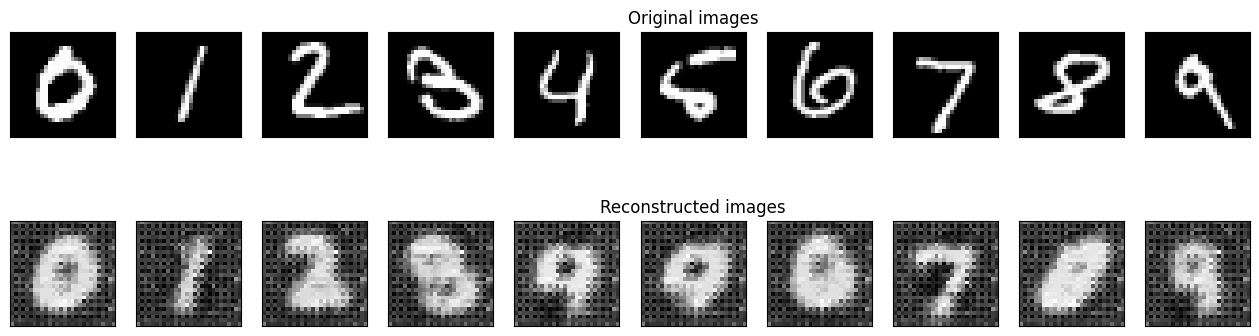

	 partial train loss (single batch): 0.064609
	 partial train loss (single batch): 0.065906
	 partial train loss (single batch): 0.065330
	 partial train loss (single batch): 0.067124
	 partial train loss (single batch): 0.065592
	 partial train loss (single batch): 0.064847
	 partial train loss (single batch): 0.063523
	 partial train loss (single batch): 0.064267
	 partial train loss (single batch): 0.064453
	 partial train loss (single batch): 0.063614
	 partial train loss (single batch): 0.063083
	 partial train loss (single batch): 0.064055
	 partial train loss (single batch): 0.062802
	 partial train loss (single batch): 0.064104
	 partial train loss (single batch): 0.063557
	 partial train loss (single batch): 0.061717
	 partial train loss (single batch): 0.061865
	 partial train loss (single batch): 0.062953
	 partial train loss (single batch): 0.062319
	 partial train loss (single batch): 0.061464
	 partial train loss (single batch): 0.061404
	 partial train loss (single batch

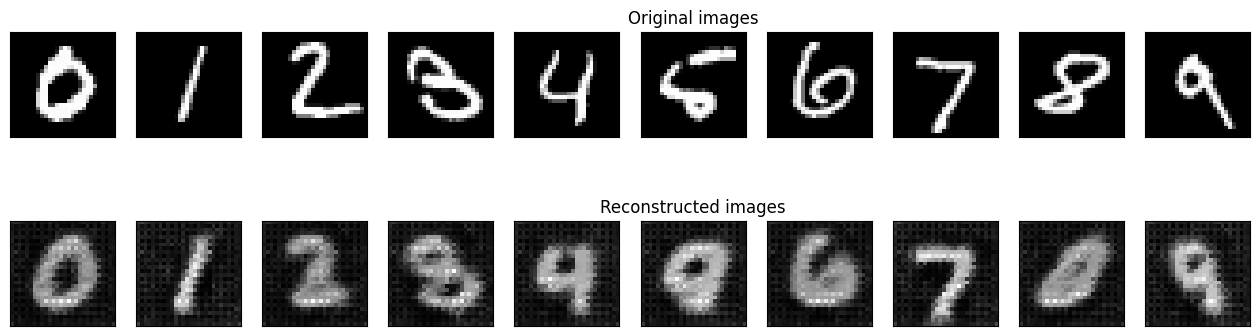

	 partial train loss (single batch): 0.044697
	 partial train loss (single batch): 0.046822
	 partial train loss (single batch): 0.045922
	 partial train loss (single batch): 0.048668
	 partial train loss (single batch): 0.046796
	 partial train loss (single batch): 0.046135
	 partial train loss (single batch): 0.045006
	 partial train loss (single batch): 0.046319
	 partial train loss (single batch): 0.045855
	 partial train loss (single batch): 0.045927
	 partial train loss (single batch): 0.045369
	 partial train loss (single batch): 0.046670
	 partial train loss (single batch): 0.044693
	 partial train loss (single batch): 0.046925
	 partial train loss (single batch): 0.046618
	 partial train loss (single batch): 0.044383
	 partial train loss (single batch): 0.044807
	 partial train loss (single batch): 0.046435
	 partial train loss (single batch): 0.045749
	 partial train loss (single batch): 0.044846
	 partial train loss (single batch): 0.044829
	 partial train loss (single batch

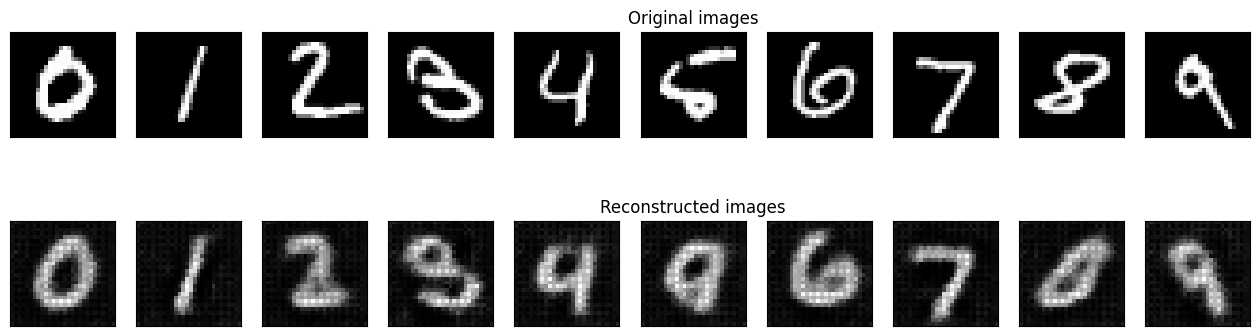

	 partial train loss (single batch): 0.035403
	 partial train loss (single batch): 0.037937
	 partial train loss (single batch): 0.036769
	 partial train loss (single batch): 0.040303
	 partial train loss (single batch): 0.037797
	 partial train loss (single batch): 0.037652
	 partial train loss (single batch): 0.036548
	 partial train loss (single batch): 0.037514
	 partial train loss (single batch): 0.037631
	 partial train loss (single batch): 0.037800
	 partial train loss (single batch): 0.036996
	 partial train loss (single batch): 0.038166
	 partial train loss (single batch): 0.035998
	 partial train loss (single batch): 0.038300
	 partial train loss (single batch): 0.037930
	 partial train loss (single batch): 0.035748
	 partial train loss (single batch): 0.036658
	 partial train loss (single batch): 0.037665
	 partial train loss (single batch): 0.036640
	 partial train loss (single batch): 0.036529
	 partial train loss (single batch): 0.035990
	 partial train loss (single batch

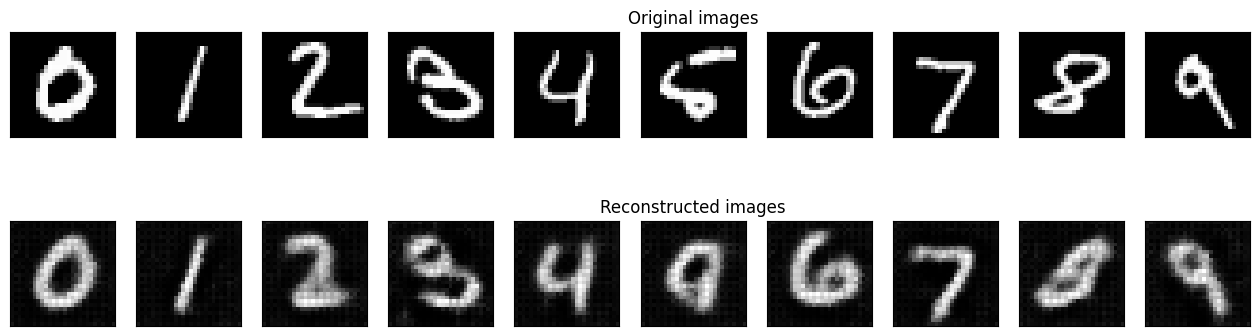

	 partial train loss (single batch): 0.030999
	 partial train loss (single batch): 0.033652
	 partial train loss (single batch): 0.032542
	 partial train loss (single batch): 0.036060
	 partial train loss (single batch): 0.033894
	 partial train loss (single batch): 0.033765
	 partial train loss (single batch): 0.032777
	 partial train loss (single batch): 0.033576
	 partial train loss (single batch): 0.034061
	 partial train loss (single batch): 0.034090
	 partial train loss (single batch): 0.033072
	 partial train loss (single batch): 0.034293
	 partial train loss (single batch): 0.032058
	 partial train loss (single batch): 0.034376
	 partial train loss (single batch): 0.034271
	 partial train loss (single batch): 0.031693
	 partial train loss (single batch): 0.033047
	 partial train loss (single batch): 0.033711
	 partial train loss (single batch): 0.032631
	 partial train loss (single batch): 0.032750
	 partial train loss (single batch): 0.031954
	 partial train loss (single batch

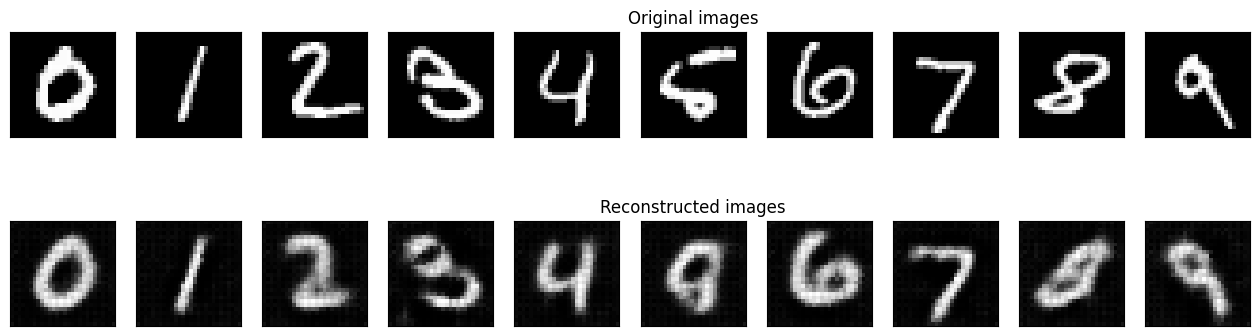

In [7]:
num_epochs = 5
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

In [8]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.031665340065956116

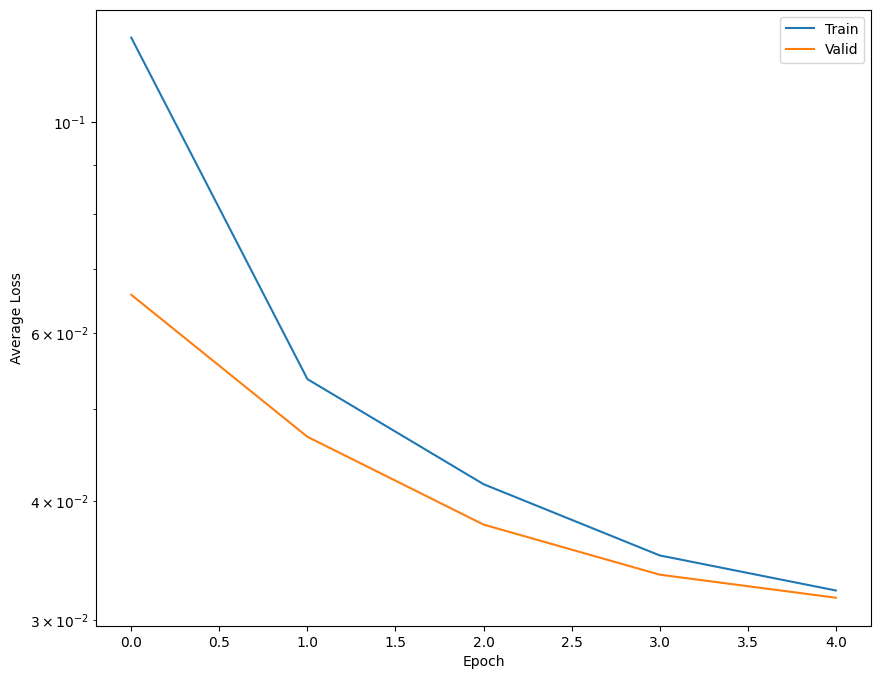

In [9]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

## 2. Object Detection Example

In [12]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

img = read_image("grace_hopper_517x606.jpg")

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im.show()

/Users/admin/anaconda3/lib/python3.11/site-packages/torchvision/utils.py:224: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")
